# 3D VoCC with a cylindrical shaped kernel

The notebook compares the results of VoCC using no depth information and 3D VoCC with a cylindircal kernel.
The cylinder is applied in the mask while the depth information of the particles is binned.

In [1]:
from py_eddy_tracker.dataset.grid import UnRegularGridDataset
from datetime import datetime
import numpy as np
from VoCC import VortexCorrelationClustering

%run ../scripts/experiment_utils.py

MIN_PARTICLES = 40

In [2]:
def get_py_eddy_tracker_labels():
    g = UnRegularGridDataset('../data/ssh_u_v_1d_20111029.nc',
                        'nav_lon', 'nav_lat', centered=True)
    g.high_filter('ssh',w_cut=700,factor=8.0)
    date = datetime(2011,10,29)
    a,c = g.eddy_identification('ssh', 'u', 'v', date = date, step=0.004, shape_error=70)


    # Load the particles dataset

    coordinates = np.load('../data/particles_29102011.npy')
    X,Y,U,V = coordinates[::3].T

    # The magnitude of the movement are two days we normalize them to one.
    U /= 2
    V /= 2
    # Set outliers to zero
    U[U > 1] = 0
    V[V > .5] = 0

    def extract_lagrangian_eddies(eddy_dataset, particles_x, particles_y, particle_threshold):
        counts, _ = np.histogram(eddy_dataset.contains(particles_x, particles_y), bins = np.arange( len(eddy_dataset)+1))
        mask_indices = np.argwhere(counts >= particle_threshold).squeeze()

        mask = np.zeros(len(eddy_dataset.obs), dtype=bool)
        mask[mask_indices] = True

        return eddy_dataset.extract_with_mask(mask)


    particle_eddy_a = extract_lagrangian_eddies(a, X, Y, MIN_PARTICLES).contains(coordinates[:,0],coordinates[:, 1])
    particle_eddy_c = extract_lagrangian_eddies(c, X, Y, MIN_PARTICLES).contains(coordinates[:,0],coordinates[:, 1])

    particle_eddy_c[particle_eddy_c >= 0] += particle_eddy_a.max() +1

    particle_eddy_labels = np.max(np.vstack((particle_eddy_a, particle_eddy_c)), axis = 0)
    return particle_eddy_labels

particle_eddy_labels = get_py_eddy_tracker_labels()

In [4]:
coordinates = np.load('../data/particles_29102011_depth.npy')
X,Y,U,V,D = coordinates.T

# The magnitude of the movement are two days we normalize them to one.
U /= 2
V /= 2
# Set outliers to zero
U[U > 1] = 0
V[V > .5] = 0

In [5]:
vocc = VortexCorrelationClustering(
    radii=np.arange(4,24,4),
    cell_size= .07, 
    sectors = 15, 
    circle_coverage_rate = .75, 
    qth_threshold = .99, 
    min_points = .01
)
default_labels = vocc.fit(coordinates).labels_

In [6]:
depth_steps = 6
vocc = VortexCorrelationClustering(
    radii=np.arange(4,24,4),
    cell_size= .07, 
    sectors = 15, 
    circle_coverage_rate = .75, 
    qth_threshold = .99, 
    min_points = .01,
    depth_boundaries=-depth_layers[::depth_steps],
    cylindrical= True
)
layered_labels = vocc.fit(coordinates).labels_

<GeoAxes: >

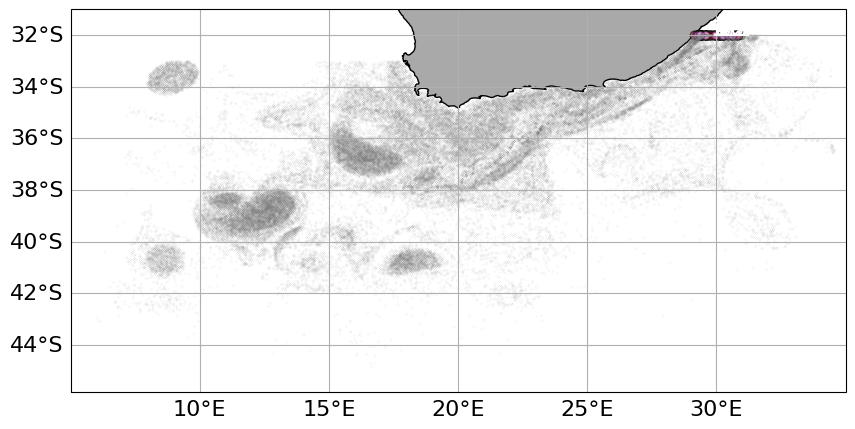

In [7]:
create_real_world_image(coordinates, layered_labels, f'62-cylinder-{depth_steps}depth', True)


In [8]:
from sklearn.metrics import adjusted_rand_score
label_mask = particle_eddy_labels > -1
print('A-Rand score for py-eddy-tracker and both VoCC ideas:')
print(f'2D VoCC vs py_eddy-tracker: {adjusted_rand_score(particle_eddy_labels[label_mask], default_labels[label_mask]):.4f}')
print(f'3D VoCC vs py_eddy-tracker: {adjusted_rand_score(particle_eddy_labels[label_mask], layered_labels[label_mask]):.4f}')

A-Rand score for py-eddy-tracker and both VoCC ideas:
2D VoCC vs py_eddy-tracker: 0.9110
3D VoCC vs py_eddy-tracker: 0.0000


In [9]:
# Comparing different deoth steps
rand_score = []

for i in range(1,50,2):
    vocc = VortexCorrelationClustering(
        radii=np.arange(4,24,4),
        cell_size= .07, 
        sectors = 15, 
        circle_coverage_rate = .75, 
        qth_threshold = .99, 
        min_points = .01,
        depth_boundaries=-depth_layers[::i],
        cylindrical= True
    )
    layered_labels = vocc.fit(coordinates).labels_

    rand_score.append( adjusted_rand_score(particle_eddy_labels[label_mask], layered_labels[label_mask]))

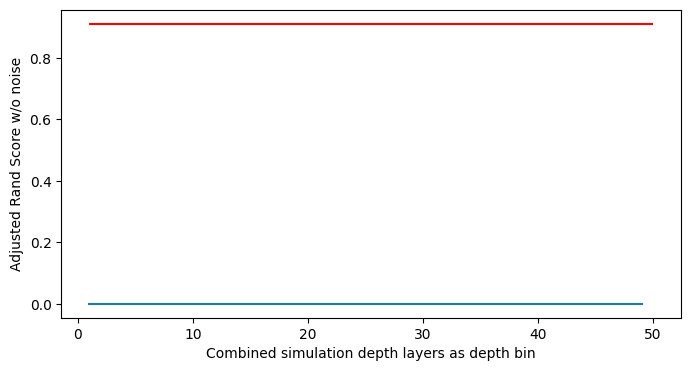

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1,50,2), rand_score)
ax.hlines(adjusted_rand_score(particle_eddy_labels[label_mask], default_labels[label_mask]), 1, 50, label='Default VoCC', color='red')

ax.set_xlabel('Combined simulation depth layers as depth bin')
ax.set_ylabel('Adjusted Rand Score w/o noise')

plt.savefig('../fig/62-arand-vs-depth.png')